### *PhotoDissociation Region Toolbox Notebooks*
-------------------------------------------------------------

# Example 3: Determining Radiation Field and Density

This example shows use the PDRT Toolbox to determine the PDR radiation field $G_0$ and hydrogen nucleus volume density $n$ from your spectral line and far-infrared (FIR) data into the PDR Toolbox.  The case is for single-pixel observations (as in the classic PDRT website).   If you have not gone through the Measurements and ModelSets examples, you should do them first.

[`LineRatioFit`](https://pdrtpy.readthedocs.io/en/latest/pdrtpy.tool.html#lineratiofit) is a tool to fit observations of intensity ratios to a set of PDR models. It takes as input a set of observations with errors represented as [`Measurements`](https://pdrtpy.readthedocs.io/en/latest/pdrtpy.measurement.html) and  [`ModelSet`](https://pdrtpy.readthedocs.io/en/latest/pdrtpy.modelset.html) for the models to which the data will be fitted. The observations should be spectral line or continuum intensities.  They can be spatial maps or single pixel values. They should have the same spatial resolution.  

The models to be fit are stored as intensity ratios.  The input observations will be use to create ratios that correspond to models.  From there a minimization fit is done to determine the density and radiation field that best fit the data.At least 3 observations are needed in order to make at least 2 ratios.  With fewer ratios, no fitting can be done. More ratios generally means better determined density and radiation field, assuming the data are consistent with each other.   

Once the fit is done, [`LineRatioPlot`](https://pdrtpy.readthedocs.io/en/latest/pdrtpy.plot.html#lineratioplot) can be used to view the results.


### Radiation Field and Density from single value Measurements
Following the example on how to use Measurements, create Measurements for your observations.

In [27]:
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
import pdrtpy.pdrutils as utils
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.plot.lineratioplot import LineRatioPlot
from astropy.nddata import StdDevUncertainty
import astropy.units as u
import numpy as np
import corner
from copy import deepcopy

In [28]:
myunit = "erg s-1 cm-2 sr-1" # default unit for value and error
m1 = Measurement(data=3.6E-4,uncertainty = StdDevUncertainty(1.2E-4),
                 identifier="OI_63",unit=myunit)
m2 = Measurement(data=1E-6,uncertainty = StdDevUncertainty([3E-7]),
                 identifier="CI_609",unit=myunit)
m3 = Measurement(data=26,uncertainty = StdDevUncertainty([5]),
                 identifier="CO_43",restfreq="461.04077 GHz", unit="K km/s")
m4 = Measurement(data=8E-5,uncertainty = StdDevUncertainty([8E-6]),
                 identifier="CII_158",unit=myunit)
a = [m1,m2,m3,m4]

Now create the fitting tool, feeding it your observations.   

In [29]:
ms = ModelSet("wk2020",z=1)
p = LineRatioFit(ms,measurements=a) 

In [32]:
ms._all_models

PDR code,name,version,path,filename,medium,z,mass,description
,,,,,,,solMass,
str15,str13,str7,str48,str10,str16,float64,float64,str116
Wolfire/Kaufman,wk2006,2006,wolfirekaufman/version2006/constant_density/z=1/,models.tab,constant density,1.0,--,Wolfire/Kaufman 2006 constant density models
Wolfire/Kaufman,wk2006,2006,wolfirekaufman/version2006/constant_density/z=3/,models.tab,constant density,3.0,--,Wolfire/Kaufman 2006 constant density models
Wolfire/Kaufman,wk2020,2020,wolfirekaufman/version2020/constant_density/z=1/,models.tab,constant density,1.0,--,"Wolfire/Kaufman 2020 constant density models, $A_V$=7, no freeze-out"
Wolfire/Kaufman,smc,2006,wolfirekaufman/version2006/constant_density/smc/,models.tab,constant density,0.1,--,Wolfire/Kaufman 2006 limited set of constant density models for Small Magellanic Cloud
Wolfire/Kaufman,lmc,2020,wolfirekaufman/version2020/constant_density/lmc/,models.tab,constant density,0.5,--,"Wolfire/Kaufman 2020 limited set of constant density models for Large Magellanic Cloud, surface chemistry turned off"
KOSMA-tau,kt2013wd01-7,WD01-7,kosmatau/2013/WD01-7/clumpy/Z=1/M=100/,models.tab,clumpy,1.0,100.0,"KOSMA-tau 2013 models, Weingarter & Draine 2001 $R_V$=3.1, clumpy, maximum clump mass = 100 M$_\odot$"
...,...,...,...,...,...,...,...,...
KOSMA-tau,kt2013wd01-7,WD01-7,kosmatau/2013/WD01-7/clumpy/Z=1/M=1000/,models.tab,clumpy,1.0,1000.0,"KOSMA-tau 2013 models, Weingarter & Draine 2001 $R_V$=3.1, clumpy, maximum clump mass = 1000 M$_\odot$"


### Now run it! 
Note the K km s$^{-1}$ get converted on the fly to erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$.  You will get warned that there are no beam parameters in the Measurements.  The default fitting method is least-squares, but other methods are available. (see https://lmfit.github.io/lmfit-py/fitting.html )

In [4]:
p.run()

/home/mpound/src/pdrtpy/pdrtpy/tool/lineratiofit.py:384: UserWarning: LineRatioFit: No beam parameters in Measurement headers, assuming they are all equal!
  self._check_compatibility()


Converting K km/s to erg / (cm2 s sr) using Factor = +1.004E-07 g / (cm K s2)
fitted 1 of 1 pixels
got 0 exceptions


### The results are stored in member variables as Measurements and in an `lmfit.ModelResult` object.


In [5]:
# ModelResult
p.fit_result[0]

#### `pdrutils` has methods to convert between the common radiation field measures. 

In [6]:
print(f"Density = {p.density:3.2e}")
print(f"Radiation Field = {p.radiation_field:3.2e}")
# example conversions
print(f"{utils.toDraine(p.radiation_field):3.2f}")
print(f"{utils.tocgs(p.radiation_field):3.2e}")
print(f"{utils.toMathis(p.radiation_field):3.2e}")

Density = 4.07e+04 +/- 2.47e+03 1 / cm3
Radiation Field = 3.58e-01 +/- 3.95e-02 erg / (cm2 s)
131.68 +/- 14.53 Draine
3.58e-01 +/- 3.95e-02 erg / (cm2 s)
1.98e+02 +/- 2.18e+01 Mathis


## Now on to plotting!
Create a plotter from the tool.  For single pixel measurements, you can plot the observed ratios in (G0,n) space like the classic PDRT.  

In [7]:
plot = LineRatioPlot(p)

### LineRatioPlot has many options for how plots are displayed.
You can vary colormap, contours, units, etc.  For an exhaustive list, see the documentation web page or type `help(LineRatioPlot)`.
    

#### Plot your observed ratios with errors on the matching models.  
The observational errors are shown as shaded regions around the solid observation line. Here we also show how to change the figure size and the color use for the measurement ("observed").

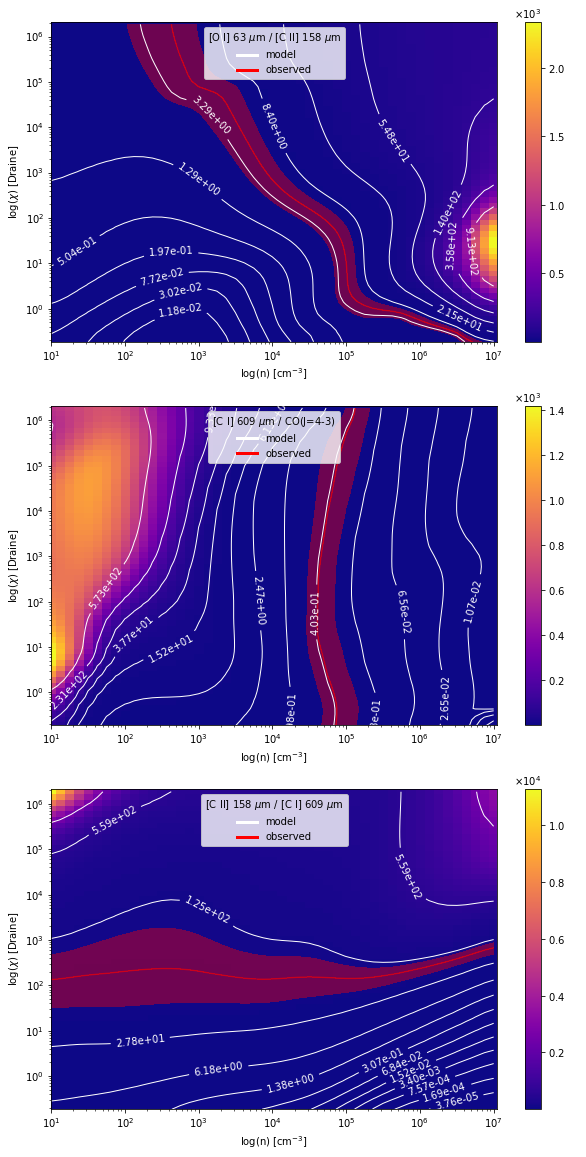

In [8]:
plot.ratios_on_models(yaxis_unit="Draine",image=True,norm='simple',ncols=1,
                      figsize=(10,20), meas_color=['red'],label=True,colorbar=True)
# Save the figure to a PNG
plot.savefig("modelfits.png")


### Do the overlay plots differently.
In this example, the figures are smaller, the normalization and colormap are changed, and we use dotted lines instead of shading to indicate the errors on the observations.

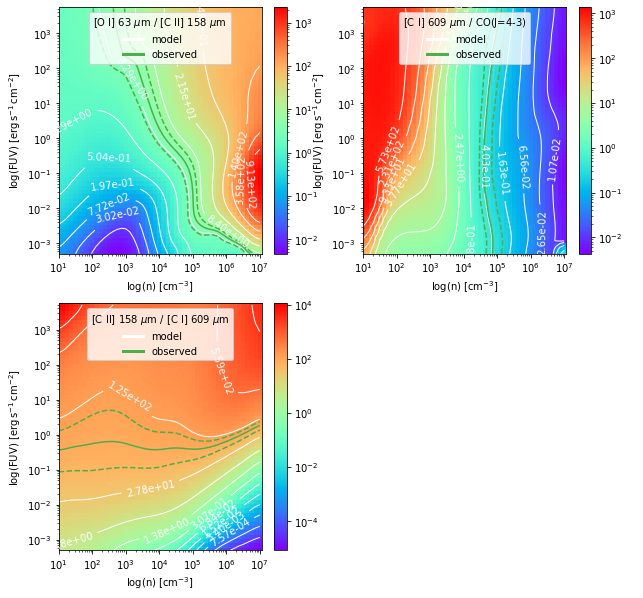

In [9]:
plot.ratios_on_models(norm='log',label=True,cmap='rainbow',shading=0,contour_color='k')

#### Plot the reduced $\chi^2$ in $(n,G_0)$ space, using an alternative colormap and label the contours

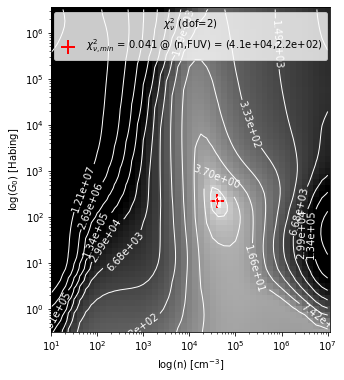

In [10]:
plot.reduced_chisq(cmap='gray_r',norm='log',label=True,colors='white',
                   legend=True,vmax=8E4,figsize=(5,7),yaxis_unit='Habing')
# save as a PNG file
plot.savefig("chisq.png")

#### How about just contours? We need to specify color since default contour color is white.  Also add a legend showing the values at the minimum.

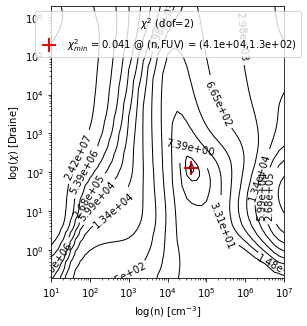

In [11]:
plot.chisq(image=False,colors='k',label=True,legend=True,yaxis_unit='Draine')

#### Plot confidence intervals.
The default levels are [50, 68, 80, 95, 99]

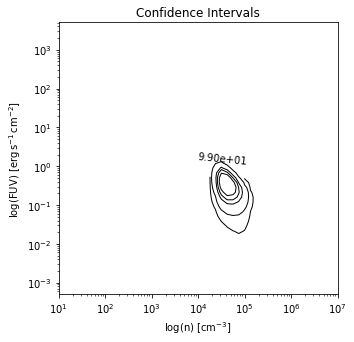

In [12]:
plot.confidence_intervals()

#### What are the model ratios matching these observations?

In [13]:
list(p._modelratios.keys())

['OI_63/CII_158', 'CI_609/CO_43', 'CII_158/CI_609']

#### Plot one of the model ratios

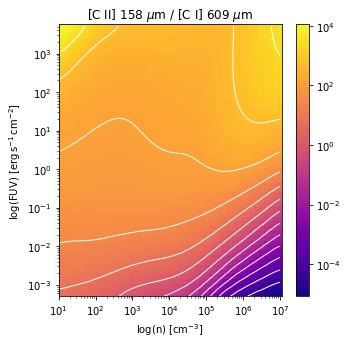

In [14]:
plot.modelratio("CII_158/CI_609",norm="log")

#### Save the most recent figure to a PNG

In [15]:
plot.savefig("CII_CI.png")

#### Overlay all the ratios and errors in model space.  
These are colloquially referred to as "spaghetti diagrams."   You can add text to the plot with text().  You can otherwise modify the plot by referencing the `_plt` attribute which is an instance of `matplotlib.pyplot`.

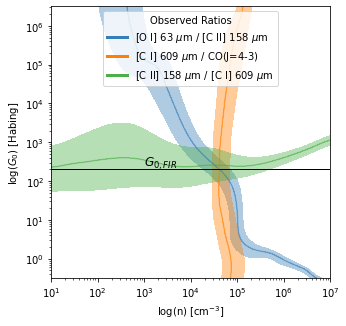

In [16]:
plot.overlay_all_ratios(yaxis_unit="Habing",figsize=(5,5))
plot.text(1000,240,r"$G_{0,FIR}$",fontsize='large',color='k')
plot._plt.hlines(200,10,1E7,color='k',linewidth=1)
plot.savefig("overlayratios.png")

### Add intensities to the plot
The default is to show ratios.  You can add intensities through the `measurements` keyword. This example also shows how to change the legend location.

Converting K km/s to erg / (cm2 s sr) using Factor = +1.004E-07 g / (cm K s2)


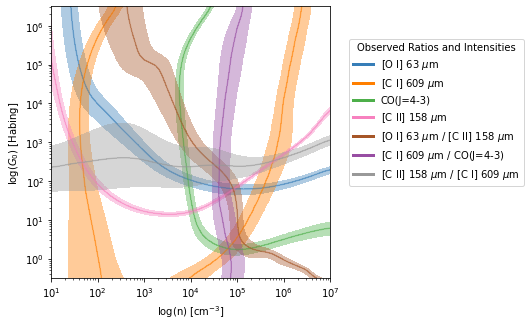

In [17]:
plot.overlay_all_ratios(yaxis_unit="Habing",
                        measurements=a,loc='upper left',
                        bbox_to_anchor=(1.05,0.9))

### Let's get all Bayesian up in this crib
Instead of least-squares, you can use the emcee package to do Monte Carlo Markov Chain analysis to determine $n$ and $I_{FUV}$.
Note: this can take a few minutes.

*Caution: This method is computationally expensive so is not (yet) recommended for maps!*

In [18]:
p.run(method='emcee',steps=2000,nwalkers=200)

/home/mpound/src/pdrtpy/pdrtpy/tool/lineratiofit.py:384: UserWarning: LineRatioFit: No beam parameters in Measurement headers, assuming they are all equal!
  self._check_compatibility()


Converting K km/s to erg / (cm2 s sr) using Factor = +1.004E-07 g / (cm K s2)


100%|███████████████████████████████████████████████| 2000/2000 [01:22<00:00, 24.32it/s]


fitted 1 of 1 pixels
got 0 exceptions


In [19]:
print(f' n = {p.density:.2e}\nI(FUV) = {p.radiation_field:.2e}')
p.fit_result[0]

 n = 4.48e+04 +/- 1.74e+04 1 / cm3
I(FUV) = 3.79e-01 +/- 2.18e-01 erg / (cm2 s)


### You can make the traditional corner plots

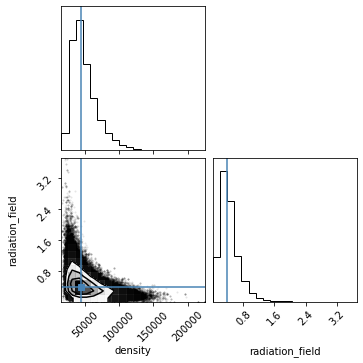

In [20]:
res = p.fit_result[0]
fig = corner.corner(res.flatchain, labels=res.var_names, 
                    truths=list(res.params.valuesdict().values()))

### The model radiation fields are in ${\rm erg~s^{-1}~cm^{-2}}$.  Here's a trick if you want to convert the corner plot to Habing

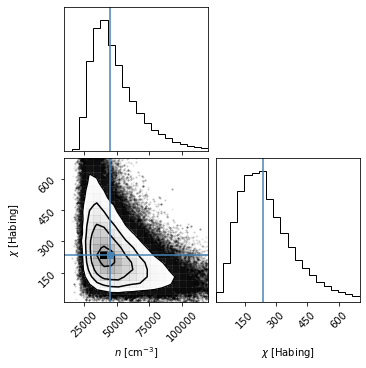

In [21]:
# from copy import deepcopy  [i moved the import to the first cell]
scale = 1.6E-3 # 1 habing = 1.6E-3 erg s-1 cm-2
# copy the results table
rescopy = deepcopy(res.flatchain)

# scale the radiation_field column of the table.
rescopy['radiation_field'] /= scale

# now copy and scale the "best fit" values where the cross hairs are plotted.
truths=np.array(list(res.params.valuesdict().values()))
truths[1] /=scale

#fig = corner.corner(rescopy, labels=["$n$","$G_0$"], truths=truths)

fig = corner.corner(rescopy, bins=20,range=[(1E4,1.2E5),(10,700)],
                    labels=[r"$n~{\rm [cm^{-3}]}$",r"$\chi~{\rm [Habing]}$"],
                    truths=truths)
fig.savefig("corner.png",dpi=300,facecolor='white',transparent=False)

# What if you want to fit multiple sets of measurements that aren't in map form?
You can do a bulk import and fit by
reading in tables that contain intensities for individual lines to 
create a `Measurement` instance containing a 1-D array of data points using [*Measurement.from_table()*.](http://pdrtpy.readthedocs.io/en/latest/pdrtpy.measurement.html#pdrtpy.measurement.Measurement.from_table)  

Below is an example using \[C II\], CO(3-2), and FIR data on the source RCW 49 from [Tiwari et al. 2021.](https://ui.adsabs.harvard.edu/abs/2021ApJ...914..117T/abstract)  In this example, the tables are in IPAC format, but any Astropy supported table format is acceptable.  

In [22]:
m1 = Measurement.from_table("rcw49_nc_cii158.tab")
m2 = Measurement.from_table("rcw49_nc_co32.tab")
m3 = Measurement.from_table("rcw49_nc_fir.tab")
# Tiwari et al used wk2006 ModelSet
ms = ModelSet("wk2020",z=1)
lrf = LineRatioFit(ms,measurements=[m1,m2,m3])
# run it
lrf.run()

/home/mpound/src/pdrtpy/pdrtpy/tool/lineratiofit.py:384: UserWarning: LineRatioFit: No beam parameters in Measurement headers, assuming they are all equal!
  self._check_compatibility()


  0%|          | 0/56 [00:00<?, ?it/s]

fitted 56 of 56 pixels
got 0 exceptions


Plotting in `LineRatioPlot` is set up to handle single pixels or spatial maps, rather than vectors, s you can use that here. But you can examine the inputs and results in a table.  The `table` property returns the inputs and fits in an astropy Table.   If you have not yet called `run()` it will include only your input `Measurements`.
Note the $\chi^2$ here are infinitesimal because there are only 2 parameters (ratios) for 2 unknowns, so the fit is "perfect."

In [23]:
t=lrf.table
t.show_in_notebook()

idx,CII_158,CO_32,FIR,CII_158/CO_32,CII_158/FIR,Radiation Field,H2 Volume Density,Chi-square
,erg / (cm2 s sr),erg / (cm2 s sr),erg / (cm2 s sr),,,erg / (cm2 s),1 / cm3,
0,4.97E-04,1.51E-06,2.16E-01,3.30E+02,2.31E-03,1.40E+00,5.46E+03,9.21E-27
1,6.14E-04,2.44E-06,1.60E-01,2.51E+02,3.85E-03,6.89E-01,6.72E+03,8.80E-25
2,6.05E-04,1.75E-06,1.67E-01,3.45E+02,3.63E-03,7.40E-01,4.35E+03,6.60E-26
3,6.02E-04,1.29E-06,1.84E-01,4.66E+02,3.28E-03,8.08E-01,2.96E+03,5.74E-25
4,5.49E-04,1.12E-06,2.01E-01,4.89E+02,2.74E-03,1.03E+00,2.94E+03,9.77E-26
5,4.98E-04,1.28E-06,2.29E-01,3.88E+02,2.17E-03,1.48E+00,4.38E+03,1.13E-25
6,5.05E-04,1.38E-06,2.37E-01,3.66E+02,2.13E-03,1.53E+00,4.84E+03,4.05E-26
7,5.65E-04,1.60E-06,2.18E-01,3.53E+02,2.59E-03,1.17E+00,4.78E+03,1.00E-26
8,5.28E-04,1.68E-06,1.90E-01,3.14E+02,2.77E-03,1.09E+00,5.48E+03,2.08E-26


#### From here you can use matplotlib tools to explore the data further.
For example, below is a plot of two intensity ratios.

Text(0, 0.5, 'CII_158/CO_32')

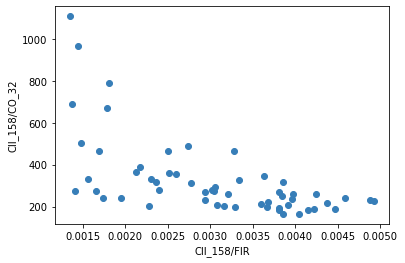

In [24]:
import matplotlib.pyplot as plt
x='CII_158/FIR'
y='CII_158/CO_32'
plt.scatter(t[x],t[y])
plt.xlabel(x)
plt.ylabel(y)

#### This shows a scatter plot of CII 158 $\mu$m intensity vs. $G_0$.   

Text(0, 0.5, 'Radiation Field [erg / (cm2 s)]')

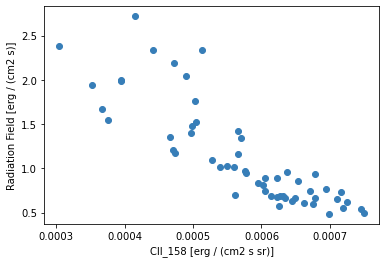

In [25]:
x='CII_158'
y='Radiation Field'
plt.scatter(t[x],t[y])
plt.xlabel(f'{x} [{t[x].unit}]')
plt.ylabel(f'{y} [{t[y].unit}]')


#### And here is $n$ vs. $G_0$

(56,) (56,)


Text(0, 0.5, '$G_0$ [erg / (cm2 s)]')

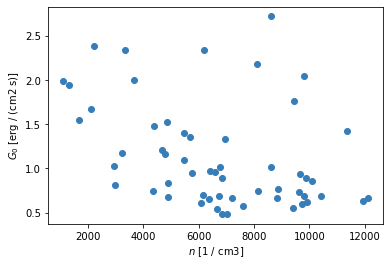

In [26]:
y='Radiation Field'
x='H2 Volume Density'
print(t[x].shape,t[y].shape)
plt.scatter(t[x],t[y])
plt.xlabel(r'$n$'+f' [{t[x].unit}]')
plt.ylabel(r'$G_0$'+f' [{t[y].unit}]')